In [117]:
# simple implementation of CAM in PyTorch for the networks such as ResNet, DenseNet, SqueezeNet, Inception

import io
import requests
from PIL import Image
from torchvision import models, transforms
from torch.autograd import Variable
from torch.nn import functional as F
import torch
import numpy as np
import cv2

In [96]:
# input image
LABELS_URL = 'https://s3.amazonaws.com/outcome-blog/imagenet/labels.json'
IMG_URL = 'http://media.mlive.com/news_impact/photo/9933031-large.jpg'

In [97]:
# networks such as googlenet, resnet, densenet already use global average pooling at the end, so CAM could be used directly.
model_id = 2
if model_id == 1:
    net = models.squeezenet1_1(pretrained=True)
    finalconv_name = 'features' # this is the last conv layer of the network
elif model_id == 2:
    net = models.resnet18(pretrained=True)
    finalconv_name = 'layer4'
elif model_id == 3:
    net = models.densenet161(pretrained=True)
    finalconv_name = 'features'

net.eval()

ResNet (
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (relu): ReLU (inplace)
  (maxpool): MaxPool2d (size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1))
  (layer1): Sequential (
    (0): BasicBlock (
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU (inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    )
    (1): BasicBlock (
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU (inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d

In [98]:
# hook the feature extractor
features_blobs = []
def hook_feature(module, input, output):
    features_blobs.append(output.data.cpu().numpy())

net._modules.get(finalconv_name).register_forward_hook(hook_feature)

# get the softmax weight
params = list(net.parameters())
weight_softmax = np.squeeze(params[-2].data.numpy())

In [99]:
normalize = transforms.Normalize(
   mean=[0.485, 0.456, 0.406],
   std=[0.229, 0.224, 0.225]
)
preprocess = transforms.Compose([
   transforms.Scale((224,224)),
   transforms.ToTensor(),
   normalize
])

In [100]:
response = requests.get(IMG_URL)
img_pil = Image.open(io.BytesIO(response.content))
img_pil.save('test.jpg')

img_tensor = preprocess(img_pil)
img_variable = Variable(img_tensor.unsqueeze(0))
logit = net(img_variable)

# download the imagenet category list
classes = {int(key):value for (key, value)
          in requests.get(LABELS_URL).json().items()}

h_x = F.softmax(logit).data.squeeze()
probs, idx = h_x.sort(0, True)

In [101]:
# get the softmax weight
for name, param in net.named_parameters():
    print(name, param.size())

conv1.weight torch.Size([64, 3, 7, 7])
bn1.weight torch.Size([64])
bn1.bias torch.Size([64])
layer1.0.conv1.weight torch.Size([64, 64, 3, 3])
layer1.0.bn1.weight torch.Size([64])
layer1.0.bn1.bias torch.Size([64])
layer1.0.conv2.weight torch.Size([64, 64, 3, 3])
layer1.0.bn2.weight torch.Size([64])
layer1.0.bn2.bias torch.Size([64])
layer1.1.conv1.weight torch.Size([64, 64, 3, 3])
layer1.1.bn1.weight torch.Size([64])
layer1.1.bn1.bias torch.Size([64])
layer1.1.conv2.weight torch.Size([64, 64, 3, 3])
layer1.1.bn2.weight torch.Size([64])
layer1.1.bn2.bias torch.Size([64])
layer2.0.conv1.weight torch.Size([128, 64, 3, 3])
layer2.0.bn1.weight torch.Size([128])
layer2.0.bn1.bias torch.Size([128])
layer2.0.conv2.weight torch.Size([128, 128, 3, 3])
layer2.0.bn2.weight torch.Size([128])
layer2.0.bn2.bias torch.Size([128])
layer2.0.downsample.0.weight torch.Size([128, 64, 1, 1])
layer2.0.downsample.1.weight torch.Size([128])
layer2.0.downsample.1.bias torch.Size([128])
layer2.1.conv1.weight tor

In [102]:
CAMs[0].shape

(256, 256)

In [103]:
weight_softmax[0].shape

(512,)

In [104]:
features_blobs[0].shape

(1, 512, 7, 7)

In [211]:
list(net.children())

[Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False),
 BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True),
 ReLU (inplace),
 MaxPool2d (size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1)),
 Sequential (
   (0): BasicBlock (
     (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
     (relu): ReLU (inplace)
     (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
   )
   (1): BasicBlock (
     (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
     (relu): ReLU (inplace)
     (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
   )
 ),
 Sequential (
  

In [214]:
features = []
# hook the feature extractor
def extract_feature(net, x):
    prev_feat = x
    for i, module in enumerate(list(net.children())[7]):
        print(i)
        next_feat = module(prev_feat)
        print(next_feat.size())
        features.append(next_feat.data.numpy())
        prev_feat = next_feat

In [215]:
extract_feature(net, Variable(torch.randn(1,256,16,16)))
print(features[-1].shape)

0
torch.Size([1, 512, 8, 8])
1
torch.Size([1, 512, 8, 8])
(1, 512, 8, 8)


In [111]:
def returnCAM(feature_conv, weight_softmax, class_idx):
    # generate the class activation maps upsample to 256x256
    size_upsample = (256, 256)
    bz, nc, h, w = feature_conv.shape
    output_cam = []
    for idx in class_idx:
        cam = weight_softmax[class_idx].dot(feature_conv.reshape((nc, h*w)))
        print(cam[0])
        cam = cam.reshape(h, w)
        cam = cam - np.min(cam)
        cam_img = cam / np.max(cam)
        cam_img = np.uint8(255 * cam_img)
        output_cam.append(cv2.resize(cam_img, size_upsample))
    return output_cam

In [112]:
# output the prediction
for i in range(0, 5):
    print('{:.3f} -> {}'.format(probs[i], classes[idx[i]]))

# generate class activation mapping for the top1 prediction
CAMs = returnCAM(features_blobs[0], weight_softmax, [idx[0]])


# render the CAM and output
print('output CAM.jpg for the top1 prediction: %s'%classes[idx[0]])
img = cv2.imread('test.jpg')
height, width, _ = img.shape
heatmap = cv2.applyColorMap(cv2.resize(CAMs[0],(width, height)), cv2.COLORMAP_JET)
result = heatmap * 0.3 + img * 0.5
cv2.imwrite('CAM2.jpg', result)

0.437 -> mountain bike, all-terrain bike, off-roader
0.131 -> alp
0.119 -> bicycle-built-for-two, tandem bicycle, tandem
0.108 -> unicycle, monocycle
0.049 -> lakeside, lakeshore
[  0.58665174   1.42595279   2.02319574   2.92307615   3.79935741
   6.08150434   6.79580307   2.78808999   4.0599227    4.75475073
   5.4071722    7.1512928    9.73416901   9.53509235   3.07154369
   5.23696995   5.64043903   9.22570992  17.34580803  20.43162537
  18.47678566   5.88856792   8.46051693   8.35038471  14.13038063
  29.81113625  37.45700836  32.70554352   4.42532349   5.29907179
   4.3736496   11.75062561  31.57415199  42.57767487  35.67827225
   3.33864999   3.00276566   1.86304879   6.94642067  21.16878128
  29.84524345  24.81092644   3.62147951   2.69970655   1.29211819
   2.41011453   6.41694546   9.68650246   7.77257824]
output CAM.jpg for the top1 prediction: mountain bike, all-terrain bike, off-roader


True

In [107]:
idx[0]

671

In [108]:
CAMs[0].shape

(256, 256)

In [74]:
CAMs

[array([[ 0,  0,  0, ..., 37, 37, 37],
        [ 0,  0,  0, ..., 37, 37, 37],
        [ 0,  0,  0, ..., 37, 37, 37],
        ..., 
        [18, 18, 18, ..., 43, 43, 43],
        [18, 18, 18, ..., 43, 43, 43],
        [18, 18, 18, ..., 43, 43, 43]], dtype=uint8)]

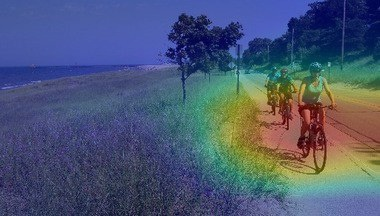

In [61]:
from IPython.display import Image
Image(filename='CAM2.jpg') 